 # Bayesian Models for Match Score Prediction



 This notebook demonstrates how to use Bayesian models to predict match scores using the `ssat` library.

 ## Importing Libraries



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ssat.bayesian.poisson_models import Poisson
from ssat.bayesian.skellam_models import Skellam
from ssat.data import get_sample_handball_match_data


 ## Understanding the Models



 When a model is instantiated, it will print how the data should be parsed for STAN. The two models, Poisson and Skellam, are different:



 - **Poisson**: Predicts the total goals for each team separately.

 - **Skellam**: Predicts the goal difference directly (home goals - away goals).



 The difference is demonstrated in the plotted team stats and in the predictions, particularly in the probability of a draw.

 ## Preparing the Data



 We will create a DataFrame containing the home and away teams.

In [2]:
matches = pd.DataFrame(
    {
        "home_team": [
            "Czech Republic",
            "Estonia",
            "Greece",
            "Montenegro",
            "Turkey",
            "Luxembourg",
            "Faroe Islands",
            "North Macedonia",
            "Georgia",
            "Finland",
            "Austria",
            "Poland",
            "Serbia",
            "Latvia",
            "Kosovo",
            "Israel",
            "France",
            "Sweden",
        ],
        "away_team": [
            "Croatia",
            "Lithuania",
            "Iceland",
            "Hungary",
            "Switzerland",
            "Belgium",
            "Netherlands",
            "Slovenia",
            "Bosnia & Herzegovina",
            "Slovakia",
            "Germany",
            "Portugal",
            "Spain",
            "Italy",
            "Ukraine",
            "Romania",
            "Denmark",
            "Norway",
        ],
    }
)

# Add index that is home_team vs away_team string
matches.index = matches.home_team + " vs " + matches.away_team


 ## Loading Historical Data



 Next, we will load historical match data.

In [ ]:
match_df = get_sample_handball_match_data()

match_df = match_df.assign(
    weights=1.0,
    goal_diff_match=match_df.home_goals - match_df.away_goals,
)

league = "European Championship"

filtered_matches = match_df.query("league == @league")
filtered_matches = filtered_matches.assign(
    spread=filtered_matches.home_goals - filtered_matches.away_goals
)
common_features = ["home_team", "away_team"]
poisson_features = ["home_goals", "away_goals"]
skellam_features = ["goal_diff_match"]


 ## Fitting Models



 We will fit two Bayesian models: Poisson and Skellam.

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

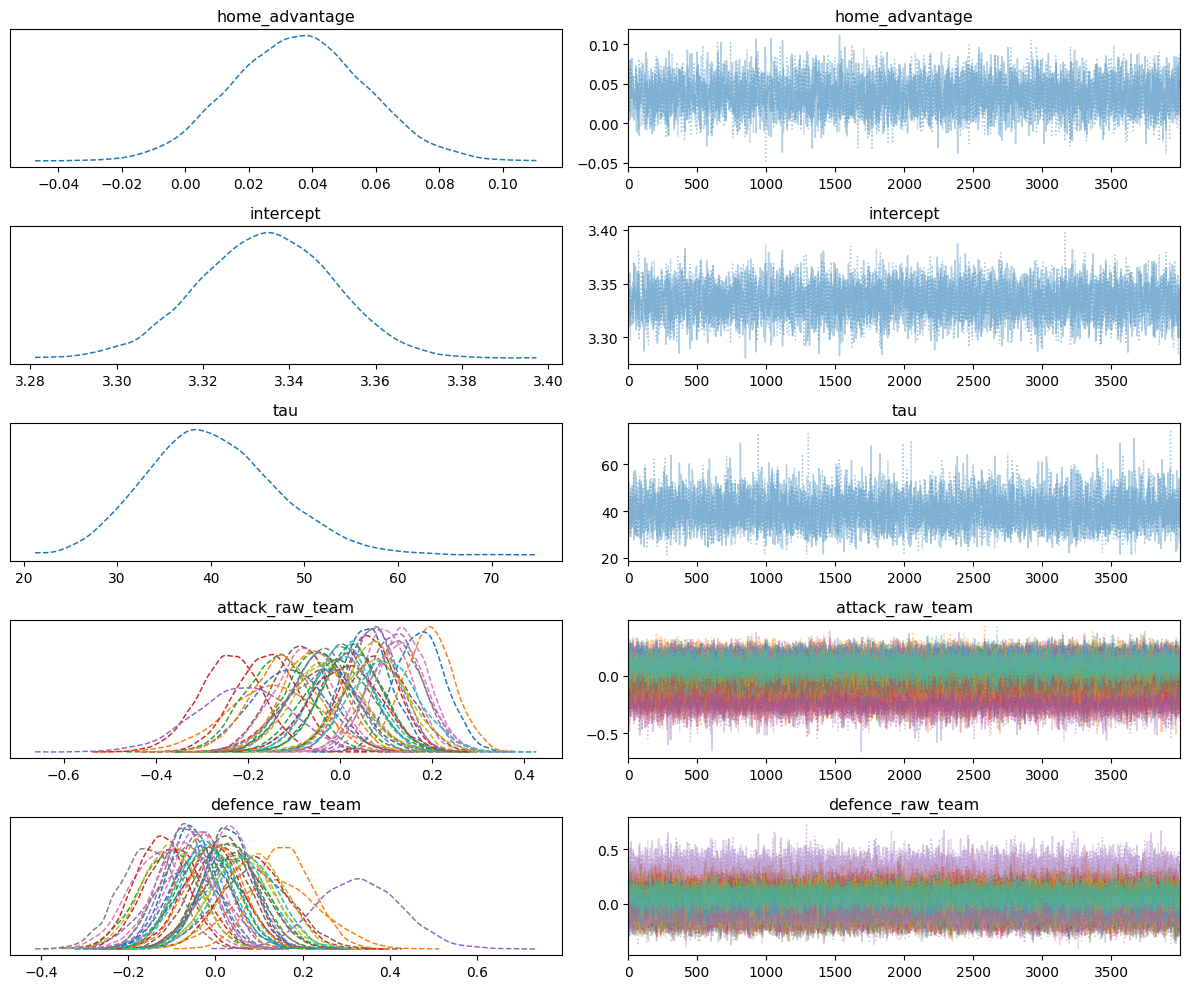

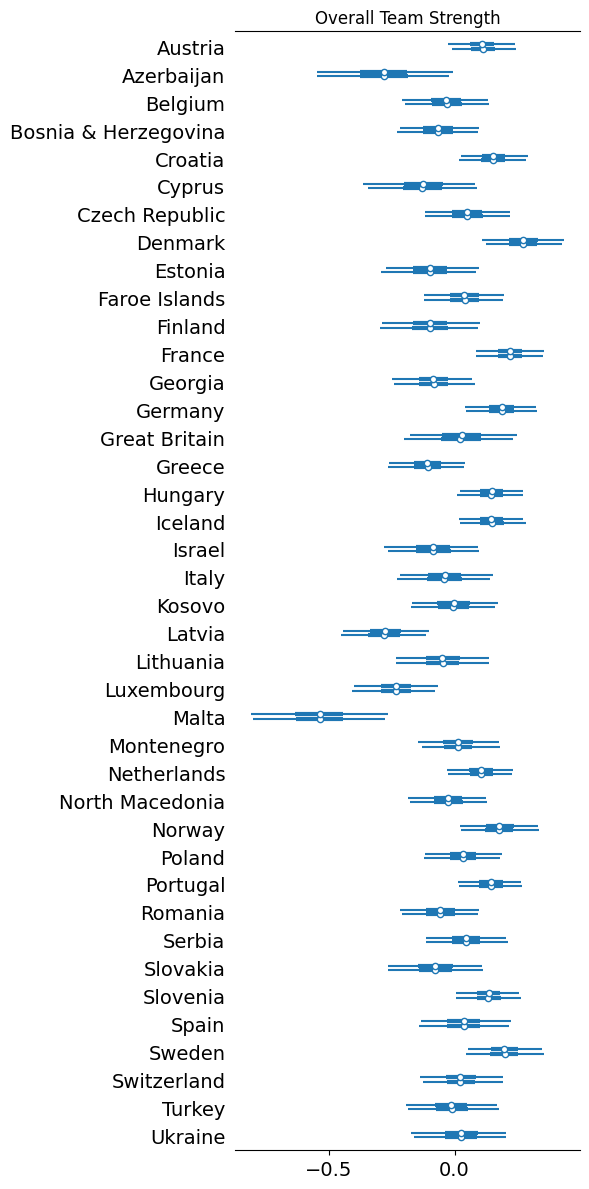

In [4]:
poisson_model = Poisson()
poisson_model.fit(
    filtered_matches[common_features], filtered_matches[poisson_features], seed=2
)
poisson_model.plot_trace()
poisson_model.plot_team_stats()

poisson_preds = poisson_model.predict(matches, format_predictions=True)
poisson_probas = poisson_model.predict_proba(matches, format_predictions=True)


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

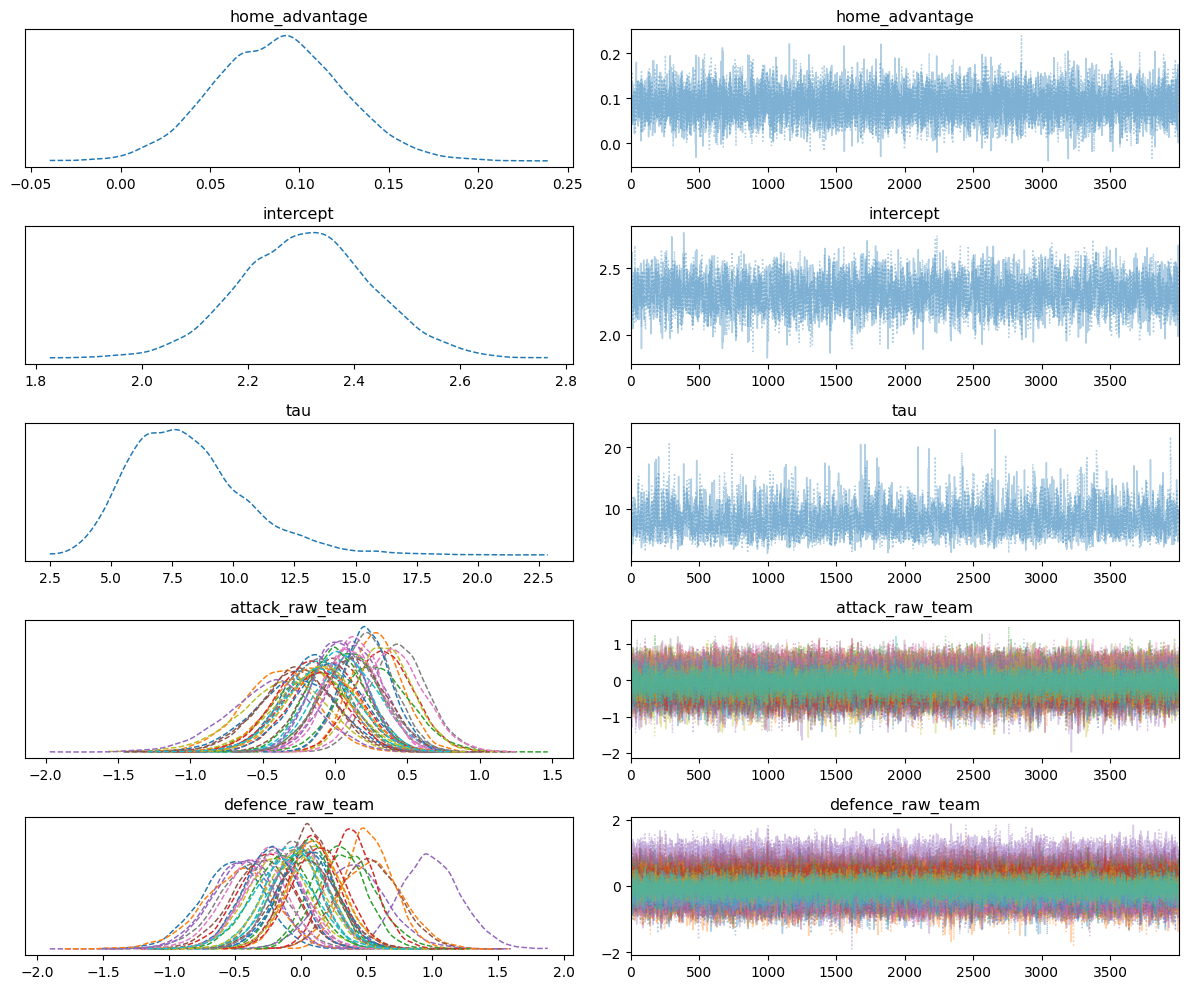

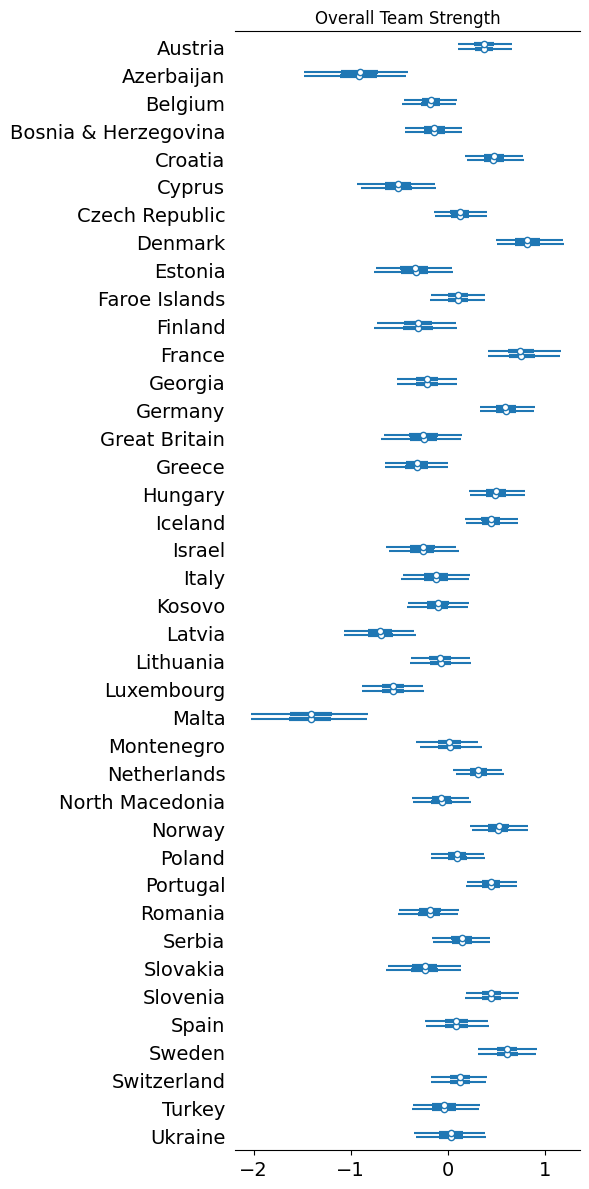

In [5]:
skellam = Skellam()
skellam.fit(
    filtered_matches[common_features], filtered_matches[skellam_features], seed=2
)
skellam.plot_trace()
skellam.plot_team_stats()

skellam_preds = skellam.predict(matches, format_predictions=True)
skellam_probas = skellam.predict_proba(matches, format_predictions=True)


 ## Displaying Predictions



 Finally, we will print the predictions from each model.

In [6]:
print("=== POISSON MODEL PREDICTIONS ===")
print("\nPredictions (Goal Difference):")
print(poisson_preds)
print("\nWin Probabilities:")
print(poisson_probas)
print("\nImplied Odds (1/probability):")
print(1 / poisson_probas)

print("\n=== SKELLAM MODEL PREDICTIONS ===")
print("\nPredictions (Goal Difference):")
print(skellam_preds)
print("\nWin Probabilities:")
print(skellam_probas)
print("\nImplied Odds (1/probability):")
print(1 / skellam_probas)


=== POISSON MODEL PREDICTIONS ===

Predictions (Goal Difference):
Czech Republic-Croatia         -2.0
Estonia-Lithuania               0.0
Greece-Iceland                 -6.0
Montenegro-Hungary             -3.0
Turkey-Switzerland              0.0
Luxembourg-Belgium             -4.0
Faroe Islands-Netherlands      -1.0
North Macedonia-Slovenia       -3.0
Georgia-Bosnia & Herzegovina    0.0
Finland-Slovakia                0.5
Austria-Germany                -1.0
Poland-Portugal                -2.0
Serbia-Spain                    2.0
Latvia-Italy                   -6.0
Kosovo-Ukraine                  0.0
Israel-Romania                  0.0
France-Denmark                 -1.0
Sweden-Norway                   2.0
Name: goal_diff, dtype: float64

Win Probabilities:
                                  home      draw      away
Czech Republic-Croatia        0.380625  0.049375  0.570000
Estonia-Lithuania             0.472625  0.044875  0.482500
Greece-Iceland                0.199375  0.038125  0.76250

 ## Model Comparison



 Let's visualize the key differences between the two models.

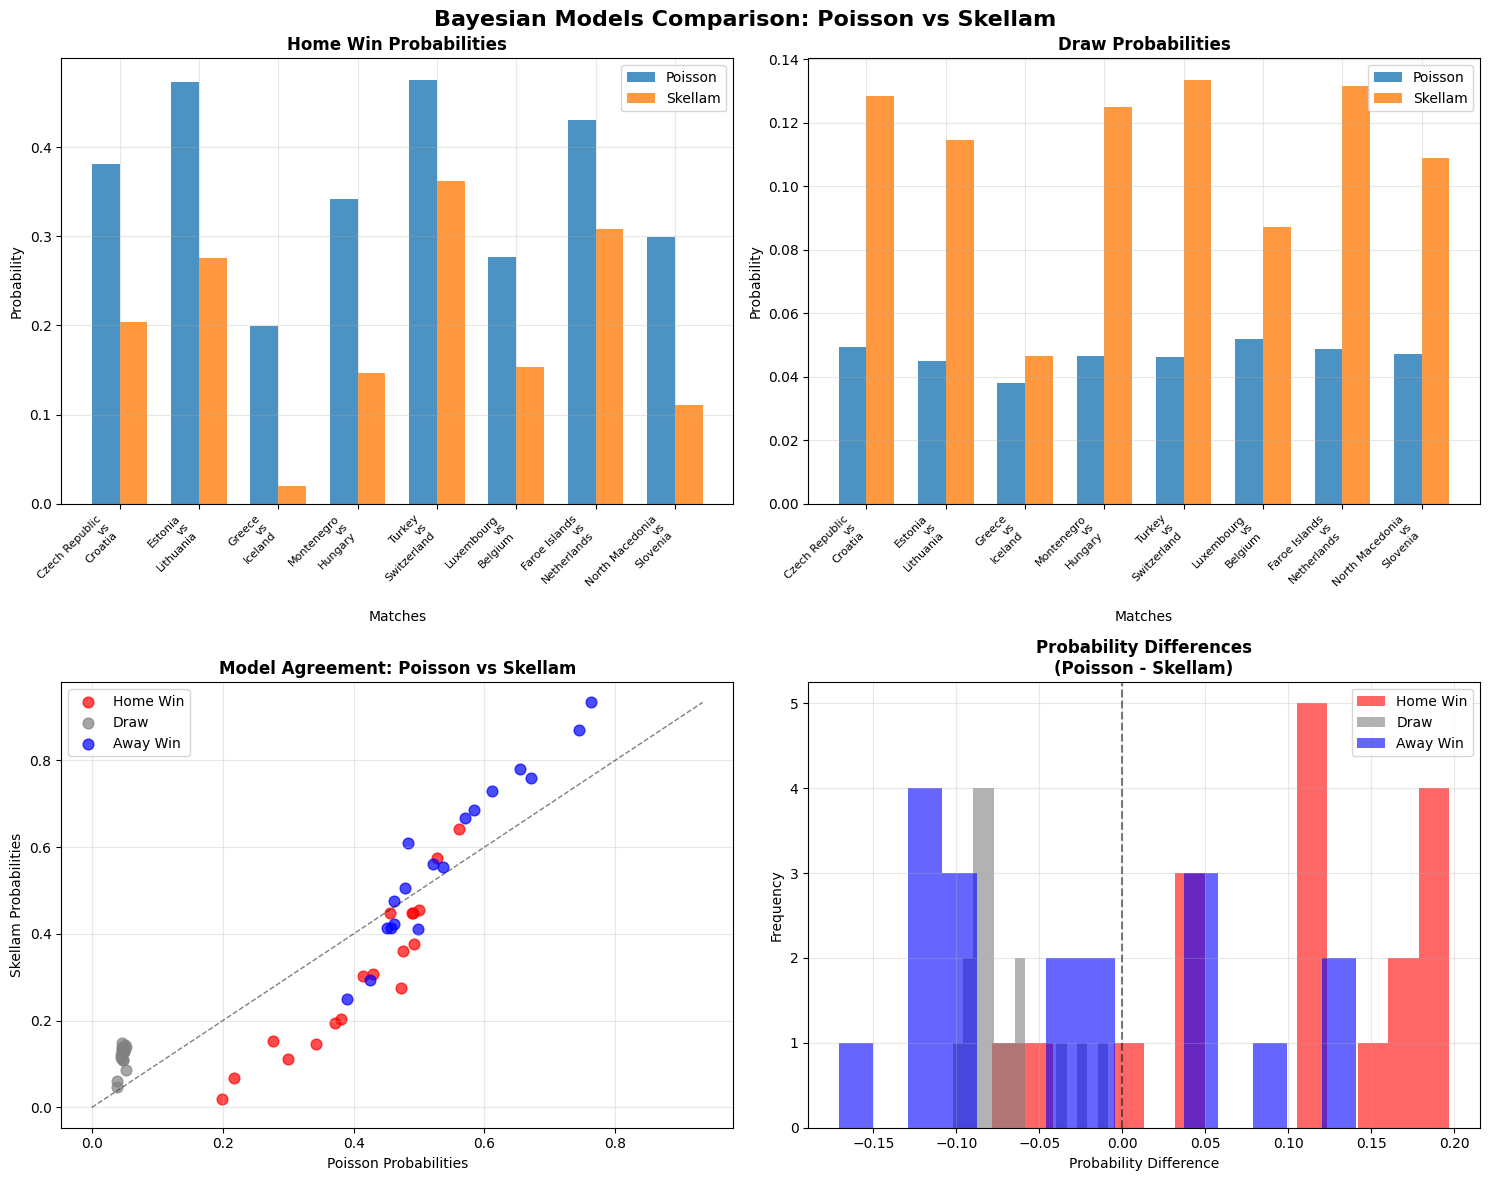


=== MODEL COMPARISON SUMMARY ===
Average Home Win Prob - Poisson: 0.411
Average Home Win Prob - Skellam: 0.307
Average Draw Prob - Poisson: 0.047
Average Draw Prob - Skellam: 0.118
Average Away Win Prob - Poisson: 0.542
Average Away Win Prob - Skellam: 0.574

Mean Absolute Difference (Home): 0.1175
Mean Absolute Difference (Draw): 0.0716
Mean Absolute Difference (Away): 0.0851


In [7]:

# Set up the plotting style
plt.style.use("default")
sns.set_palette("husl")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Bayesian Models Comparison: Poisson vs Skellam", fontsize=16, fontweight="bold"
)

# Plot 1: Win Probabilities Comparison
ax1 = axes[0, 0]
matches_subset = matches.head(8)  # Show first 8 matches for clarity
poisson_subset = poisson_probas.head(8)
skellam_subset = skellam_probas.head(8)

x_pos = range(len(matches_subset))
width = 0.35

ax1.bar(
    [x - width / 2 for x in x_pos],
    poisson_subset["home"],
    width,
    label="Poisson",
    alpha=0.8,
    color="#1f77b4",
)
ax1.bar(
    [x + width / 2 for x in x_pos],
    skellam_subset["home"],
    width,
    label="Skellam",
    alpha=0.8,
    color="#ff7f0e",
)

ax1.set_title("Home Win Probabilities", fontweight="bold")
ax1.set_xlabel("Matches")
ax1.set_ylabel("Probability")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(
    [f"{row.home_team}\nvs\n{row.away_team}" for _, row in matches_subset.iterrows()],
    rotation=45,
    ha="right",
    fontsize=8,
)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Draw Probabilities Comparison
ax2 = axes[0, 1]
ax2.bar(
    [x - width / 2 for x in x_pos],
    poisson_subset["draw"],
    width,
    label="Poisson",
    alpha=0.8,
    color="#1f77b4",
)
ax2.bar(
    [x + width / 2 for x in x_pos],
    skellam_subset["draw"],
    width,
    label="Skellam",
    alpha=0.8,
    color="#ff7f0e",
)

ax2.set_title("Draw Probabilities", fontweight="bold")
ax2.set_xlabel("Matches")
ax2.set_ylabel("Probability")
ax2.set_xticks(x_pos)
ax2.set_xticklabels(
    [f"{row.home_team}\nvs\n{row.away_team}" for _, row in matches_subset.iterrows()],
    rotation=45,
    ha="right",
    fontsize=8,
)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Probability Distribution Scatter
ax3 = axes[1, 0]
ax3.scatter(
    poisson_probas["home"],
    skellam_probas["home"],
    alpha=0.7,
    s=60,
    color="red",
    label="Home Win",
)
ax3.scatter(
    poisson_probas["draw"],
    skellam_probas["draw"],
    alpha=0.7,
    s=60,
    color="gray",
    label="Draw",
)
ax3.scatter(
    poisson_probas["away"],
    skellam_probas["away"],
    alpha=0.7,
    s=60,
    color="blue",
    label="Away Win",
)

# Add diagonal line for reference
min_val = 0
max_val = max(poisson_probas.max().max(), skellam_probas.max().max())
ax3.plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5, linewidth=1)

ax3.set_title("Model Agreement: Poisson vs Skellam", fontweight="bold")
ax3.set_xlabel("Poisson Probabilities")
ax3.set_ylabel("Skellam Probabilities")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Model Differences (Residuals)
ax4 = axes[1, 1]
prob_diff_home = poisson_probas["home"] - skellam_probas["home"]
prob_diff_draw = poisson_probas["draw"] - skellam_probas["draw"]
prob_diff_away = poisson_probas["away"] - skellam_probas["away"]

ax4.hist(prob_diff_home, bins=15, alpha=0.6, label="Home Win", color="red")
ax4.hist(prob_diff_draw, bins=15, alpha=0.6, label="Draw", color="gray")
ax4.hist(prob_diff_away, bins=15, alpha=0.6, label="Away Win", color="blue")

ax4.axvline(x=0, color="black", linestyle="--", alpha=0.5)
ax4.set_title("Probability Differences\n(Poisson - Skellam)", fontweight="bold")
ax4.set_xlabel("Probability Difference")
ax4.set_ylabel("Frequency")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== MODEL COMPARISON SUMMARY ===")
print(f"Average Home Win Prob - Poisson: {poisson_probas['home'].mean():.3f}")
print(f"Average Home Win Prob - Skellam: {skellam_probas['home'].mean():.3f}")
print(f"Average Draw Prob - Poisson: {poisson_probas['draw'].mean():.3f}")
print(f"Average Draw Prob - Skellam: {skellam_probas['draw'].mean():.3f}")
print(f"Average Away Win Prob - Poisson: {poisson_probas['away'].mean():.3f}")
print(f"Average Away Win Prob - Skellam: {skellam_probas['away'].mean():.3f}")

print(f"\nMean Absolute Difference (Home): {abs(prob_diff_home).mean():.4f}")
print(f"Mean Absolute Difference (Draw): {abs(prob_diff_draw).mean():.4f}")
print(f"Mean Absolute Difference (Away): {abs(prob_diff_away).mean():.4f}")


 ## Conclusion



 This notebook demonstrates the key differences between Poisson and Skellam models:



 - **Poisson Model**: Models individual team goal-scoring rates, leading to more spread-out probability distributions

 - **Skellam Model**: Directly models goal differences, often producing more concentrated probability estimates

 - **Draw Probabilities**: Typically differ significantly between models due to their different approaches

 - **Practical Use**: Choose based on your specific application - Poisson for detailed goal predictions, Skellam for direct win/loss/draw outcomes



 You can modify the data and models to explore further!